#### Data Extraction
extract essential information from JSON for the analysis
"title","views", "likes","comments", 'duration','tag','description', 'channel', 'category', 'published'

In [28]:
#extracting json to df
import os, json, re
import enum
import pandas as pd
import numpy as np
import glob
from datetime import datetime, timedelta, timezone
from itertools import groupby
import warnings

import pandas as pd
import gensim.downloader as api
import numpy as np
import nltk
from nltk.tokenize import sent_tokenize ,word_tokenize
from nltk.corpus import stopwords
# import nltk; nltk.download('popular')

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import MDS
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_samples, silhouette_score

warnings.simplefilter(action='ignore')
pd.set_option('display.max_columns', None)


In [29]:

# dir = 'data'
# path = os.path.join(dir, '**/*.json')
# file_list = glob.glob(path)
# print('Total number of channels ' + str(len(file_list)))
# # print(file_list)
# dfs = list()

# for file in file_list:
#     with open(file, 'r') as f:
#         data = json.load(f)
#     channel_id, stats = data.popitem()
#     pchannel_stats = stats["channel_statistics"]
#     video_stats = stats["video_data"]
#     # sorted_vids = sorted(video_stats.items(), key=lambda item: int(item[1]["viewCount"]),reverse=True)
#     vids = video_stats.items()
#     stats = []
#     for vid in vids:
#         video_id = vid[0]
#         title = vid[1]["title"]
#         try:
#             views = vid[1]["viewCount"]
#             likes = vid[1]["likeCount"]
#             duration = vid[1]['duration']
#             tags = vid[1]['tags']
#             description = vid[1]['description']
#             comments = vid[1]["commentCount"]
#             channel = vid[1]['channelTitle']
#             published = vid[1]['publishedAt'].split('T')[0]
#         except:
#             pass
#         cat = os.path.dirname(file).split('\\')[1]
#         stats.append([title,views, published, likes, comments, duration, tags, description, channel, cat])
#     vid_df = pd.DataFrame(stats, columns=["title","views", 'published',"likes","comments", 'duration','tag','description', 'channel', 'category'])
#     dfs.append(vid_df)
# df = pd.concat(dfs, ignore_index=True)
# print('Total number of videos ' + str(df.shape[0]))


In [30]:
rootdir = 'data'
feature_list = ['publishedAt', 'title', 'channelId', 'description',
                'channelTitle', 'tags', 'categoryId', 'viewCount', 
                'likeCount', 'favoriteCount', 'commentCount', 'duration',
                'definition', 'contentRating', 'topicCategories']

ov_dict_list = []
ov_temp_dict = {}

dict_list = []
temp_dict = {}

for path in glob.glob(f'./{rootdir}/*/*'):
  try:
    with open(path, "r") as read_file:
      data = json.load(read_file)
    for channel_id in data.keys():
      ov_temp_dict = data[channel_id]["channel_statistics"]
      channel_name = list(data[channel_id]["video_data"].keys())[0]
      ov_temp_dict["channelName"] = data[channel_id]["video_data"][channel_name]["channelTitle"]
      ov_dict_list.append(ov_temp_dict)
      
      for video_info in data[channel_id]["video_data"].values():
        temp_dict = video_info
        dict_list.append(temp_dict)       
  except:
    pass

overall_stats_raw_df = pd.DataFrame(ov_dict_list)
overall_stats_raw_df.drop("hiddenSubscriberCount", axis=1, inplace=True)

raw_df = pd.DataFrame(dict_list)
raw_df = raw_df[feature_list]

Data Cleaning

In [31]:
def duration_split(duration):
    try:
      for _, v in groupby(duration, str.isalpha):
        yield ''.join(v)
    except:
      yield np.nan
    
    
def duration_2_secs(duration, duration_split=duration_split):
  temp = 0
  # value = (duration_split(duration))
  for i, val in enumerate(duration_split(duration)):
    
    if len(str(duration)) <= 8:
      if i==1 and not val.isalpha():
        temp += float(val)*60
      
      if i==3 and not val.isalpha():
        temp += float(val)
    else:
      if i==1 and not val.isalpha():
        temp += float(val)*60*60
      
      if i==3 and not val.isalpha():
        temp += float(val)*60
      
      if i==5 and not val.isalpha():
        temp += float(val)

  return(temp)


# duration_2_secs("HR1PT51M12S")


In [32]:
def topic_extract(links_list):
  
  topics_list = []  
  try:
    for link in links_list:
      topics_list.append(link.split("/")[-1].lower())
    
    return(topics_list)
  except:
    pass

In [33]:
def text_prep(val):
  '''the goal is to replace the hypertexts in the 
  in any field to redundant names as vectorizing
  them could be misleading and also leak data'''

  val = str(val).lower()
  process_desc = re.sub(r'http[s]*:.*\w', 'url', val)
  process_desc = re.sub('[^a-zA-Z]', ' ', process_desc)
  process_desc = re.sub(r'\s+', ' ', process_desc)

  process_desc = nltk.sent_tokenize(process_desc)
  if not process_desc:
    process_desc = [nltk.word_tokenize(word) for word in process_desc]
  else:
    process_desc = [nltk.word_tokenize(word) for word in process_desc][0]
    
  
  word_list = [word for word in process_desc if word not in stopwords.words('english')]


  return word_list



In [34]:
def create_dataset(df, featureset, primary=True):

  if primary:
    df["publishedAt"] = pd.to_datetime(df.publishedAt, format='%Y-%m-%d')
    # df['publishedDayNum'] = df.publishedAt.apply(lambda x: x.timetuple().tm_yday)
    df['publishedDayDelta'] = (datetime.now(timezone.utc) - df['publishedAt']).apply(lambda x: x.days)
    df["categoryId"] = df.categoryId.astype(float)
    df["viewCount"] = df.viewCount.astype(float)
    df["likeCount"] = df.likeCount.astype(float)
    df["favoriteCount"] = df.favoriteCount.astype(float)
    df["commentCount"] = df.commentCount.astype(float)
    df['duration_secs'] = df.duration.apply(lambda x: duration_2_secs(x))
    df['topicCategories'] = df.topicCategories.apply(lambda x: topic_extract(x))
    # df['tags'] = df.tags.apply(lambda x: topic_extract(x))
    df['channelTitle'] = df.channelTitle.str.lower()
    # df['description'] = df.description.apply(lambda x: text_prep(x))
    # df['title'] = df.title.apply(lambda x: text_prep(x))
    df['log_duration_secs'] = np.log(df.duration_secs+1)
  
  else:
    df['ov_viewCount'] = df.viewCount.astype(float)
    df['ov_subscriberCount'] = df.subscriberCount.astype(float)
    df['ov_videoCount'] = df.videoCount.astype(float)
    df['channelName'] = df.channelName.str.lower()

  return df[featureset]

In [35]:
features = [
  'title', 'description', 'tags',
  'channelTitle', 'categoryId', 'viewCount', 
  'log_duration_secs', 'topicCategories', 'publishedDayDelta'
 ]

prep_df = create_dataset(raw_df, features)

In [36]:
pct_na = prep_df.isna().sum()/len(prep_df)*100
pct_na

title                0.000000
description          0.384914
tags                 6.080922
channelTitle         0.384914
categoryId           0.384914
viewCount            0.518640
log_duration_secs    0.000000
topicCategories      1.817952
publishedDayDelta    0.000000
dtype: float64

In [37]:
pct_dropna = len(prep_df.dropna())/len(prep_df)*100
pct_dropna

92.51133961002584

In [38]:
prep_df = prep_df.dropna()

convert text into Word2Vec

We use gensim pretrained model called 'glove-wiki-gigaword-50' with the model trained on wikipedia dataset

In [39]:
# importing pretrained gensim model to convert text tokens into vector
model_wv = api.load('glove-wiki-gigaword-50')

In [40]:
# function to convert token to word vector with word2vec finding average vector for the document
# tokenize function with df series as input to give a list of list result of each title
def df_token(df_text_series):
    # set of english stopwords
    stopset = set(stopwords.words('english'))
    token_item = []
    for t in df_text_series:
        if type(t) == list:
            t = str(' '.join(t))
        else:
            pass
        try:
            tokens = [word for word in word_tokenize(t.lower()) if word not in stopset]
        except:
            tokens == None
        token_item.append(tokens)
    return token_item

def gen_word_vec(df_text_series, wordvec):
    word_vector = []
    for token in df_token(df_text_series):
        token_considered = [t for t in token if t.isalpha]
        token_vocab = [i for i in token_considered if i in wordvec.key_to_index]
        if len(token_vocab) > 0:
            word_vector.append(np.mean(wordvec[token_vocab], axis=0))
        else:
            word_vector.append(np.zeros(wordvec.vector_size))
    word_vector = np.array(word_vector)
    return word_vector

features to work with

In [41]:
title_word_vec = gen_word_vec(prep_df.title, model_wv)
tag_word_vec = gen_word_vec(prep_df.tags, model_wv)
desc_word_vec = gen_word_vec(prep_df.description, model_wv)
topic_word_vec = gen_word_vec(prep_df.topicCategories, model_wv)

In [42]:
# with multiple features we

Reduce dimensionality using PCA

In [43]:
# initiate PCA with 1 components
pca = PCA(n_components=1)
title_pc = pca.fit_transform(title_word_vec)
tag_pc = pca.fit_transform(tag_word_vec)
desc_pc = pca.fit_transform(desc_word_vec)
topic_pc = pca.fit_transform(topic_word_vec)

In [44]:
#copy prep_df to be worked with
vec_df = prep_df.copy()
#replace df with each vector PCs
vec_df['title'] = title_pc
vec_df['tags'] = tag_pc
vec_df['description'] = desc_pc
vec_df['topicCategories'] = topic_pc

In [45]:
vec_df.sample(3)

,title,description,tags,channelTitle,categoryId,viewCount,log_duration_secs,topicCategories,publishedDayDelta
26675,-0.784201,0.306532,-0.920933,the history guy: history deserves to be rememb...,27.0,54775.0,6.651572,0.976904,253
1185,0.006324,-0.135217,0.117654,explosmentertainment,23.0,6298101.0,6.694562,2.493353,2085
35391,0.076598,0.213690,-1.694263,cnn,25.0,435864.0,5.703782,0.894577,667


In [46]:
view_vec = vec_df.drop(columns='channelTitle')

In [57]:
norm_view_vec = vec_df.copy()
norm_view_vec['averageView'] = norm_view_vec.viewCount/norm_view_vec.publishedDayDelta
norm_view_vec['normalizedView'] = norm_view_vec.groupby('channelTitle').averageView.apply(lambda x: (x-x.mean())/x.std())
norm_view_vec.drop(['channelTitle', 'viewCount', 'averageView'], axis=1, inplace=True)

In [58]:
# scale the df to be fitted with PCA
scaler = StandardScaler()
scale_view_vec = scaler.fit_transform(view_vec)
scale_norm_view_vec = scaler.fit_transform(norm_view_vec)

In [59]:
# create biplot source from https://sukhbinder.wordpress.com/2015/08/05/biplot-with-python/ + unsupervise learning class
def biplot(score, coeff, maxdim, pcax=1, pcay=2, labels=None):
    '''
    score: pca fit_transform
    coeff: components.transpose
    '''
    pca1=pcax-1
    pca2=pcay-1
    xs = score[:,pca1]
    ys = score[:,pca2]
    n = min(coeff.shape[0], maxdim)
    scalex = 2.0/(xs.max()- xs.min())
    scaley = 2.0/(ys.max()- ys.min())
    text_scale_factor = 1.5
    plt.figure(figsize=(12, 8))
    plt.scatter(xs*scalex, ys*scaley, s=1)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,pca1], coeff[i,pca2],color='r',alpha=0.5) 
        if labels is None:
            plt.text(coeff[i,pca1]* text_scale_factor, coeff[i,pca2] * text_scale_factor, "Var"+str(i+1), color='k', ha='center', va='center')
        else:
            plt.text(coeff[i,pca1]* text_scale_factor, coeff[i,pca2], labels[i], color='m', ha='center', va='center')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(pcax))
    plt.ylabel("PC{}".format(pcay))
    plt.grid()

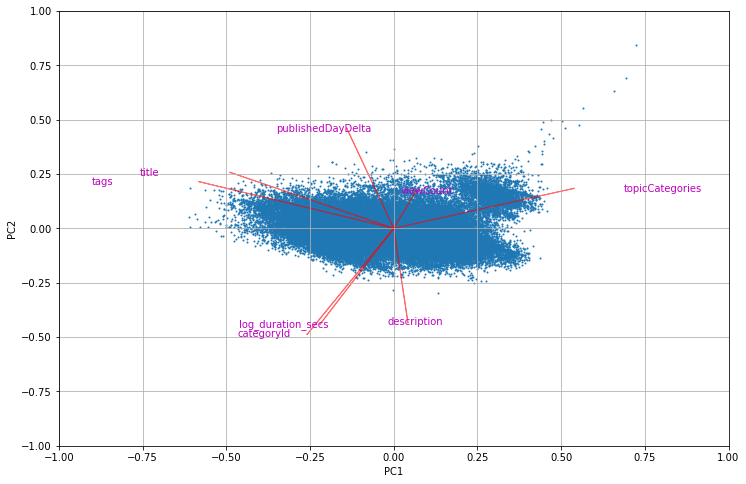

In [60]:
# biplot viewCount
score_pca = PCA(n_components=2)
score = score_pca.fit_transform(scale_view_vec)
labels = view_vec.columns
coeff = np.transpose(score_pca.components_)
biplot(score,coeff, maxdim=12, labels=labels)

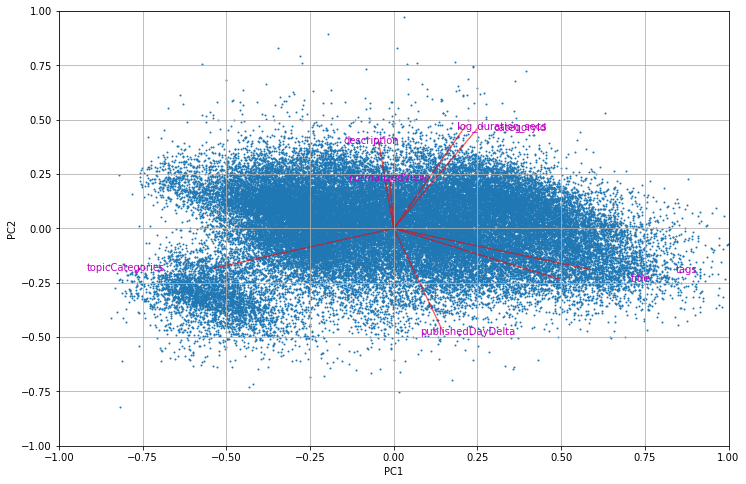

In [61]:
#biplot normalizedView
score_pca = PCA(n_components=2)
score = score_pca.fit_transform(scale_norm_view_vec)
labels = norm_view_vec.columns
coeff = np.transpose(score_pca.components_)
biplot(score,coeff, maxdim=12, labels=labels)

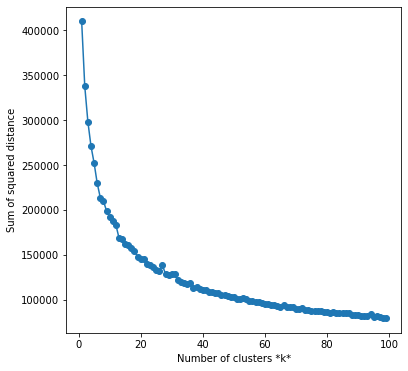

In [62]:
# Let's explore the clustering of word embadding vector using K-Means
# first let's find optimal number of cluster using elbow methods

# # stardize the data in case the data are not normalized
# df_clustering = df.copy()
# X = StandardScaler().fit_transform(df_clustering.iloc[:, 1:])

# workingin title word embedding
sse=[] # sum of square error
list_k = list(range(1, 100))

X = scale_norm_view_vec
for k in list_k:
    km = MiniBatchKMeans(n_clusters=k, init='k-means++', max_iter=300, random_state=0, batch_size=2048)
    km.fit(X)
    sse.append(km.inertia_)

plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

Let's explore silhouette plot to examine different number of cluster.

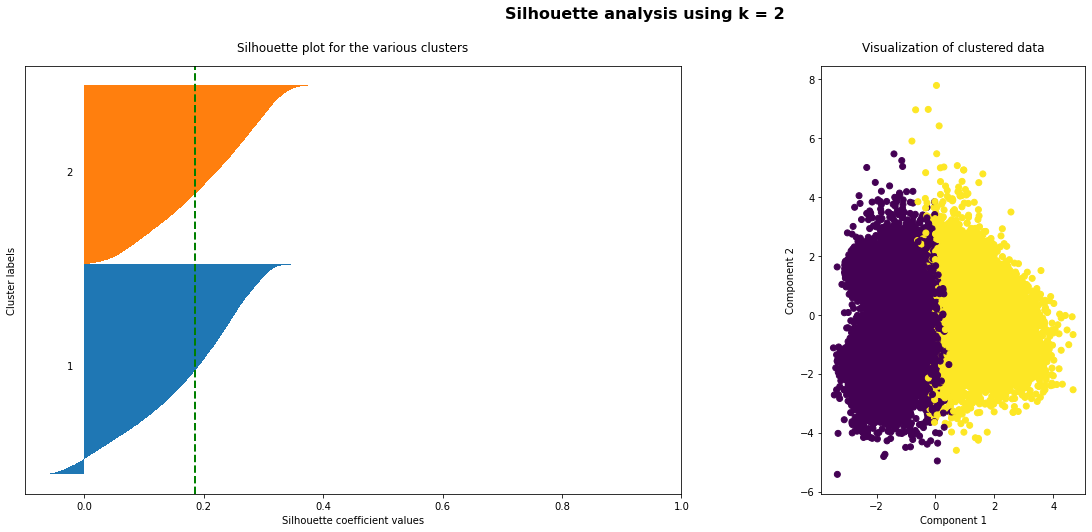

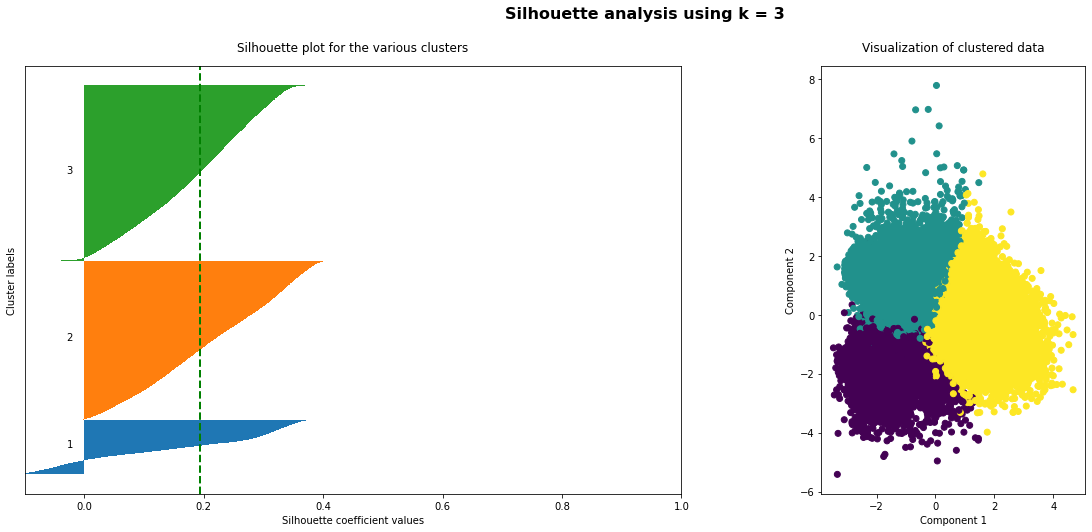

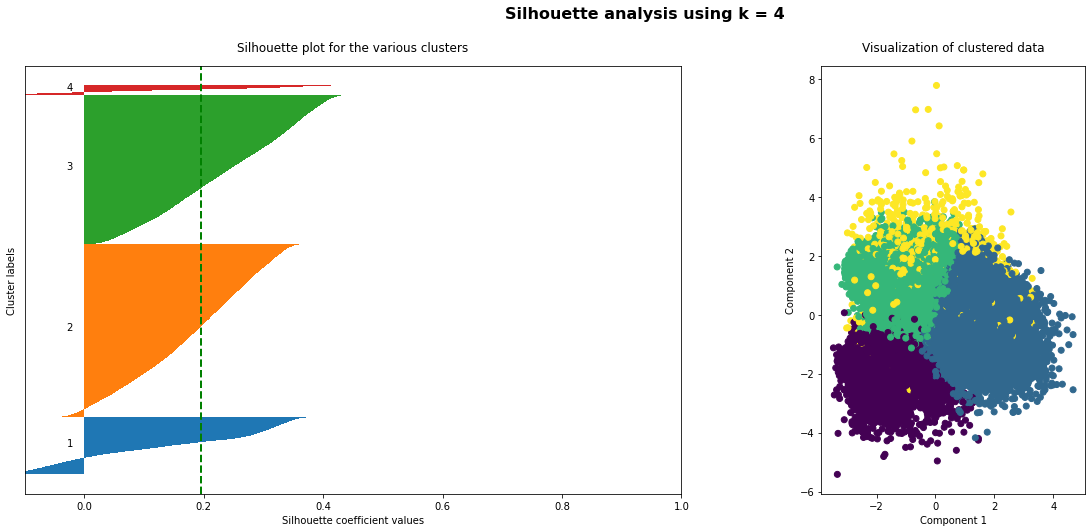

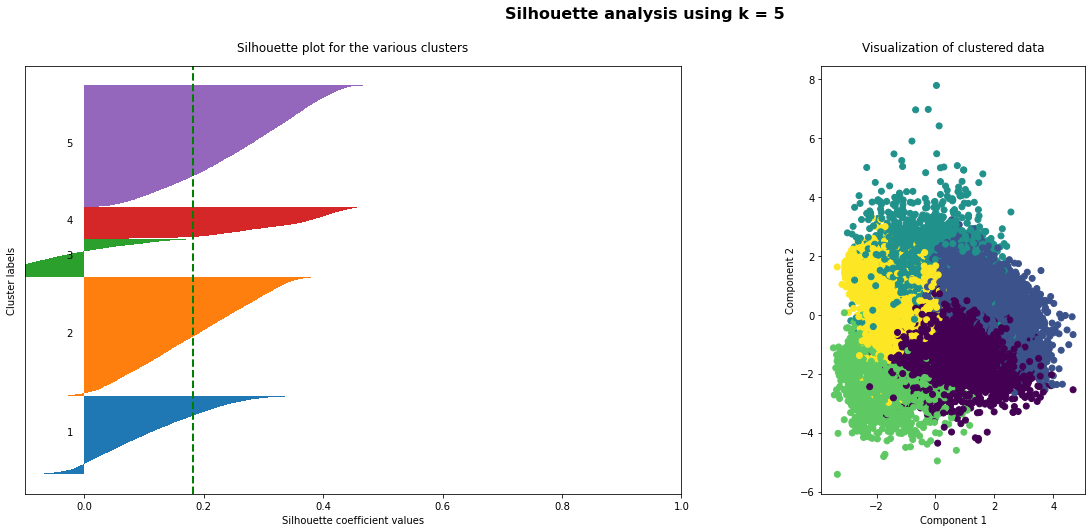

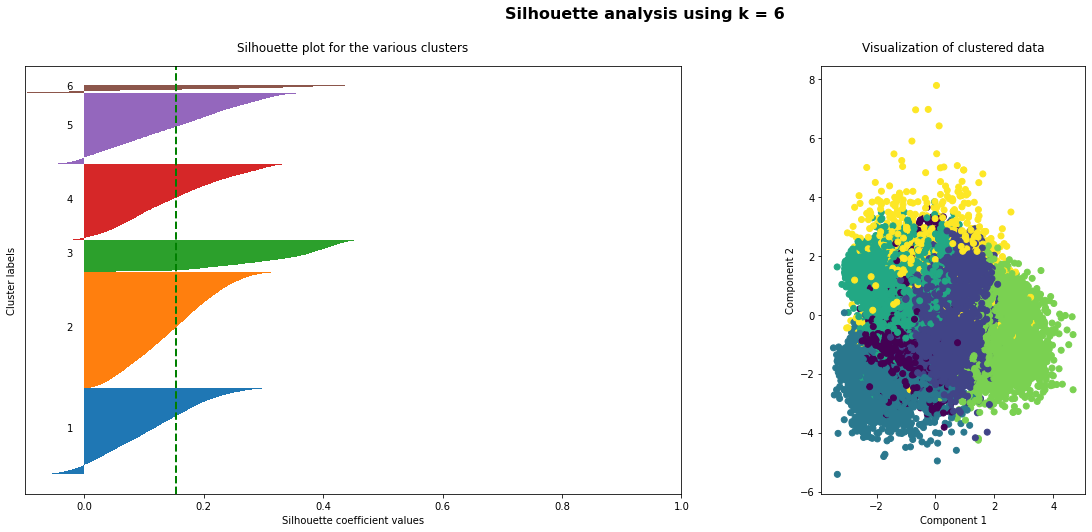

In [63]:
# use silhouette plot based on sklearn documentation page https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
#set the dataset to be working with
X = scale_norm_view_vec

for i, k in enumerate([2, 3, 4, 5, 6]):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    
    # Run the Kmeans algorithm
    kmeans = MiniBatchKMeans(n_clusters=k, init='k-means++', max_iter=300, random_state=0, batch_size=2048)
    labels = kmeans.fit_predict(X)
    # centroids = kmeans.cluster_centers_

    # Get silhouette samples
    silhouette_vals = silhouette_samples(X, labels)

    # Silhouette plot
    y_ticks = []
    y_lower, y_upper = 0, 0
    for i, cluster in enumerate(np.unique(labels)):
        cluster_silhouette_vals = silhouette_vals[labels == cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        ax1.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
        ax1.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
        y_lower += len(cluster_silhouette_vals)

    # Get the average silhouette score and plot it
    avg_score = np.mean(silhouette_vals)
    ax1.axvline(avg_score, linestyle='--', linewidth=2, color='green')
    ax1.set_yticks([])
    ax1.set_xlim([-0.1, 1])
    ax1.set_xlabel('Silhouette coefficient values')
    ax1.set_ylabel('Cluster labels')
    ax1.set_title('Silhouette plot for the various clusters', y=1.02);
    
    # Use PCA to flatten the data
    embedding = PCA(n_components=2)
    pca = pd.DataFrame(embedding.fit_transform(X), columns = ['component1','component2'])
    pca['labels'] = kmeans.predict(X)

    # Scatter plot of data colored with labels
    ax2.scatter(pca['component1'], pca['component2'], c=labels)
    # ax2.scatter(centroids[:, 0], centroids[:, 1], marker='*', c='r', s=250)
    # ax2.set_xlim([-2, 2])
    # ax2.set_xlim([-2, 2])
    ax2.set_xlabel('Component 1')
    ax2.set_ylabel('Component 2')
    ax2.set_title('Visualization of clustered data', y=1.02)
    ax2.set_aspect('equal')
    plt.tight_layout()
    plt.suptitle(f'Silhouette analysis using k = {k}',
                 fontsize=16, fontweight='semibold', y=1.05);